# Lab 04 - Bayesian Fitting
## Tasks
- Construct a Gaussian Process model and tune hyperparameters of GP model given noisy data
- Investigate what kernels can be used to best represent the data

# Set up environment

In [ ]:
!pip install git+https://github.com/uspas/optimization_and_ml --quiet

In [ ]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

import torch
import gpytorch

## Generate Data (1D)
We are going to look at some data generated by random sampling in the domain [0,1]. The function that generated this data is

$$
f(x) = \sin(2\pi x) + x
$$

The columns of the array is $(x)$. We need to convert it to a torch tensor to use with GPyTorch.

In [ ]:
x = np.random.rand(5)
train_x = x.reshape(-1,1)
train_y = np.sin(2*np.pi*train_x[:,0]) + train_x[:,0] + np.random.randn(train_x.shape[0]) * 0.01

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

## Define a GP Model
Here we define an Exact GP model using GPyTorch. The model is exact because we have analytic expressions for the integrals associated with the GP likelihood and output distribution. If we had a non-Gaussian likelihood or some other complication that prevented analytic integration we can also use Variational/Approximate/MCMC techniques to approximate the integrals necessary.

Taking a close look at the model below we see two important modules:
- ```self.mean_module``` which represents the mean function
- ```self.covar_module``` which represents the kernel function (or what is used to calculate the kernel matrix

Both of these objects are torch.nn.Module objects (see https://pytorch.org/docs/stable/generated/torch.nn.Module.html). PyTorch modules have trainable parameters which we can access when doing training. By grouping the modules inside another PyTorch module (gpytorch.models.ExactGP) lets us easily control which parameters are trained and which are not. 

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_f, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_f, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Here we initialize our model with the training data and a defined likelihood (also a nn.Module) with a trainable noise parameter.

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

NOTE: All PyTorch modules (including ExactGPModel) have ```.train()``` and ```.eval()``` modes. ```train()``` mode is for optimizing model hyperameters. ```.eval()``` mode is for computing predictions through the model posterior.

## Training the model
Here we train the hyperparameters of the model (the parameters of the covar_module and the mean_module) to maximize the marginal log likelihood (minimize the negative marginal log likelihood). Note that since everything is defined in pyTorch we can use Autograd functionality to get the derivatives which will speed up optimization using the modified gradient descent algorithm ADAM.

Also note that several of these hyperparameters (lengthscale and noise) must be strictly positive. Since ADAM is an unconstrained optimizer (which optimizes over the domain (-inf, inf)) gpytorch accounts for this constraint by optimizing the log of the lengthscale (raw_lengthscale). To get the actual lengthscale just use ```model.covar_module.base_kernel.lengthscale.item()```

<div class="alert alert-block alert-info">
    
**Task:** 
    Write the steps for minimizing the negative log likelihood using pytorch. Refer back to Lab 3 for a reminder of how to do this. Use `gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)` as the loss function (which we are trying to maximize!). Use your function to train the model and report the marginal log likelihood.
    
</div>

In [ ]:
def train_model(model, likelihood):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    

    #print the new trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')

    return loss

In [ ]:
nmll = train_model(model, likelihood)

## Plot the 1D model probability distribution

In [ ]:
#plot the gp distribution in the normalized range
x = torch.linspace(0, 1, 50).double()
model.eval()
with torch.no_grad():
    p = model(x)
    
    #get the mean
    m = p.mean
    
    #get the 2 sigma confidence region around the mean
    l,u = p.confidence_region() 

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
#plot mean and confidence region
ax.plot(x, m)
ax.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

#plot samples
ax.plot(train_x, train_y,'oC1')

## Plot the samples from the model

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  NumericalWarning,


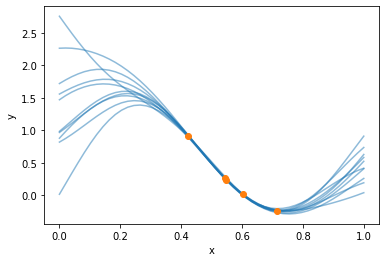

In [ ]:
#use the normalized range
x = torch.linspace(0, 1, 50).double()
#specify number of samples
n_samples = 10
model.eval()
with torch.no_grad():
    p = model(x)
    s = p.rsample(torch.Size([n_samples]))

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')

#plot samples from posterior model
for sample in s:
    ax.plot(x, sample,'C0',alpha = 0.5)

#plot measurements
ax.plot(train_x, train_y,'oC1')

## Generate Data (3D)
We are going to look at some data that was generated by sampling a 5 x 5 x 5 grid in the domain [0,1] on each axis. The function that generated this data is

$$
f(x_1,x_2,x_3) = \sin(2\pi x_1)\sin(\pi x_2) + x_3
$$

The columns of the imported array is $(x_1,x_2,x_3,f)$. We need to convert it to a torch tensor to use with GPyTorch.

In [ ]:
x = np.linspace(0,1,5)
xx = np.meshgrid(x,x,x)
train_x = np.vstack([ele.ravel() for ele in xx]).T
train_y = np.sin(2*np.pi*train_x[:,0]) * np.sin(np.pi*train_x[:,1]) + train_x[:,2] + np.random.randn(train_x.shape[0]) * 0.01

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

<div class="alert alert-block alert-info">

**Task:** 
    Define a new GP model that uses a different kernel (or combination of kernels) to maximize the marginal log likelihood.
    
</div>

In [ ]:
class MyExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_f, likelihood):
        super(MyExactGPModel, self).__init__(train_x, train_f, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
                                                   
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood.noise_covar.raw_noise : Parameter containing:
tensor([0.], requires_grad=True)
mean_module.constant : Parameter containing:
tensor([0.], requires_grad=True)
covar_module.kernels.0.raw_outputscale : 0.0
covar_module.kernels.0.base_kernel.kernels.0.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.0.raw_period_length : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.1.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.kernels.0.base_kernel.kernels.1.raw_period_length : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.kernels.1.raw_outputscale : 0.0
covar_module.kernels.1.base_kernel.raw_variance : Parameter containing:
tensor([[0.]], requires_grad=True)
Iter 1/100 - Loss: 0.931  noise: 0.693


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  NumericalWarning,


Iter 2/100 - Loss: 0.892  noise: 0.644
Iter 3/100 - Loss: 0.861  noise: 0.598
Iter 4/100 - Loss: 0.821  noise: 0.555
Iter 5/100 - Loss: 0.781  noise: 0.513
Iter 6/100 - Loss: 0.742  noise: 0.474
Iter 7/100 - Loss: 0.700  noise: 0.437
Iter 8/100 - Loss: 0.652  noise: 0.403
Iter 9/100 - Loss: 0.610  noise: 0.370
Iter 10/100 - Loss: 0.573  noise: 0.340
Iter 11/100 - Loss: 0.531  noise: 0.311
Iter 12/100 - Loss: 0.486  noise: 0.285
Iter 13/100 - Loss: 0.439  noise: 0.261
Iter 14/100 - Loss: 0.391  noise: 0.238
Iter 15/100 - Loss: 0.345  noise: 0.217
Iter 16/100 - Loss: 0.300  noise: 0.197
Iter 17/100 - Loss: 0.261  noise: 0.180
Iter 18/100 - Loss: 0.222  noise: 0.163
Iter 19/100 - Loss: 0.179  noise: 0.148
Iter 20/100 - Loss: 0.134  noise: 0.134
Iter 21/100 - Loss: 0.090  noise: 0.122
Iter 22/100 - Loss: 0.050  noise: 0.110
Iter 23/100 - Loss: 0.009  noise: 0.100
Iter 24/100 - Loss: -0.034  noise: 0.090
Iter 25/100 - Loss: -0.080  noise: 0.082
Iter 26/100 - Loss: -0.124  noise: 0.074
Iter 

tensor(-2.3637, dtype=torch.float64, grad_fn=<NegBackward0>)

<div class="alert alert-block alert-info">

**Task:** 
    Plot the mean and uncertainty along the $x_1$ axis where $x_2=\pi/2, x_3=0$.
    
</div>

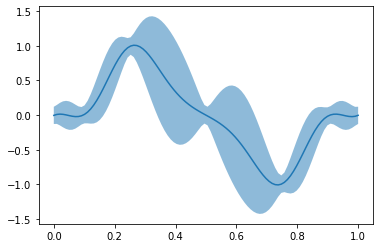